# Naive Bayes - Spam Detection

Let's create a spam detector. We'll train it on a dataset of text messages.

- use vectorization strategie of TF-IDF
- Tokenize, Lemmatization
- Train a Naive Bayes classifier with scikit learn
- Return accuracy
- Check for class imbalance
- Compute F1-score and AUC if class imbalance

In [21]:
# Let's get the data first
# data from:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
#!wget https://lazyprogrammer.me/course_files/spam.csv

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

Let's have a look at the data first.

In [23]:
df = pd.read_csv('../datasets/spam/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Let's clean up our dataset a little bit.

In [24]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df = df.rename(columns={"v1": "labels", "v2": "texts" })
df['labels'] = np.where(df["labels"] == "spam", 1, 0)
df.head()

,labels,texts
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

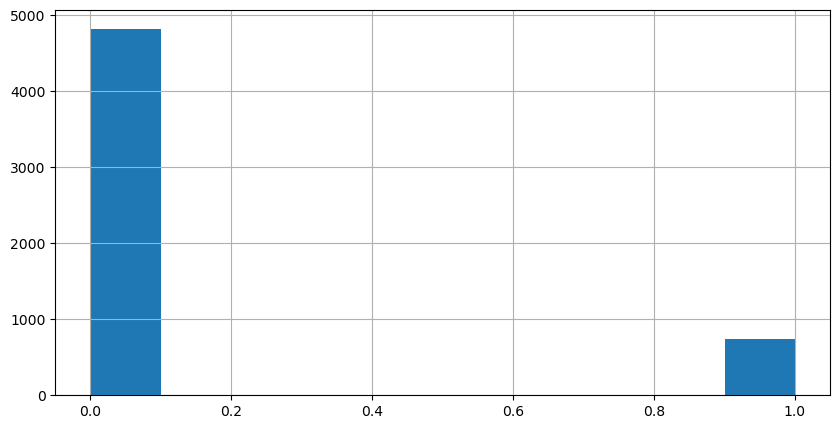

In [25]:
inputs = df['texts']
labels = df['labels']
# Let's see if we have imbalanced classes
labels.hist(figsize=(10,5))

Let's vectorize our dataset

In [26]:
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN
  
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags]

In [102]:
# vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, tokenizer=LemmaTokenizer()) #Test score 0.960 Test F1-score:  0.808 Test AUC score:  0.9843081517213657
# vectorizer = TfidfVectorizer(stop_words='english', max_features=10000) #Test score 0.974
# vectorizer = TfidfVectorizer(stop_words='english') #Test score 0.974
# vectorizer = TfidfVectorizer() #Test score 0.961
vectorizer = CountVectorizer(decode_error='ignore') #Test score 0.98 test f1-score 0.930 test auc score 0.984

# Once again, the simpler CountVectorizer has better performance.


Split our dataset into training and test set

In [123]:
inputs_train, inputs_test, Ytrain, Ytest = train_test_split(inputs, labels, random_state=123, test_size=0.33)

In [124]:
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

We have our training and test sets. Let's train the Multinomial Naive Bayes model.

In [125]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.995178140905438
test score: 0.9831430125067971


In [126]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

# Proba predictions
Ptrain_proba = model.predict_proba(Xtrain)
Ptest_proba = model.predict_proba(Xtest)

Let's compute F1-score and AUC

In [127]:
training_f1_score = f1_score(Ytrain, Ptrain)
test_f1_score = f1_score(Ytest, Ptest)

# AUC
training_auc = roc_auc_score(Ytrain, Ptrain_proba[:,1])
test_auc = roc_auc_score(Ytest, Ptest_proba[:,1])

print("Training F1-score: ", training_f1_score)
print("Test F1-score: ", test_f1_score)
print("Training AUC score: ", training_auc)
print("Test AUC score: ", test_auc)

Training F1-score:  0.9822485207100591
Test F1-score:  0.9324618736383442
Training AUC score:  0.9927335998004538
Test AUC score:  0.9815815673446167


Let's try to visualize the results with confusion matrixes

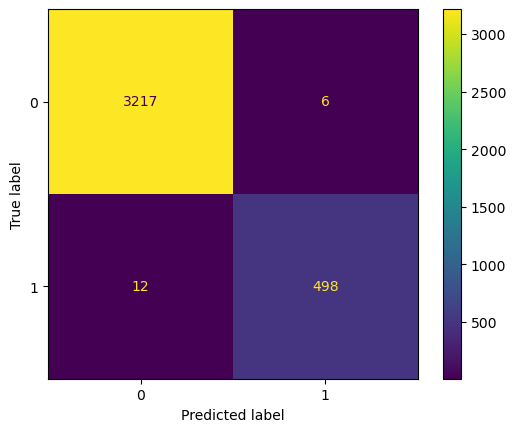

In [128]:
cm_train = confusion_matrix(Ytrain, Ptrain)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()

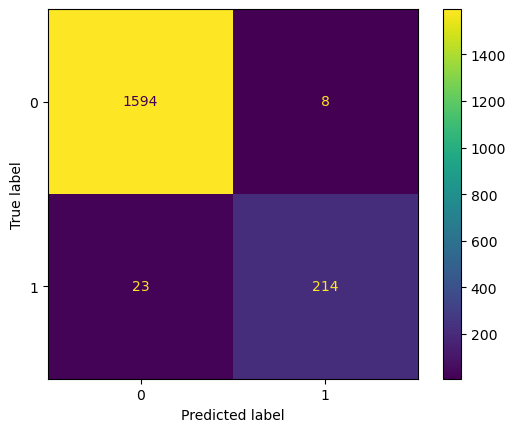

In [129]:
cm_test = confusion_matrix(Ytest, Ptest)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

Let's print the 17 false negatives

In [130]:
# see what we're getting wrong
X = vectorizer.transform(df['texts'])
df['predictions'] = model.predict(X)

In [131]:
# things that should be spam
should_be_spam = df[(df['predictions'] == 0) & (df['labels'] == 1)]['texts']
for msg in should_be_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
SMS. ac sun0819 posts HELLO:\You seem cool
Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Please CALL 08712402779 immediately as there is an urgent message waiting for you
Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA
SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO
0A

In [132]:
# things that should not be spam
should_not_be_spam = df[(df['predictions'] == 1) & (df['labels'] == 0)]['texts']
for msg in should_not_be_spam:
  print(msg)

Yes:)from last week itself i'm taking live call.
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
U WILL SWITCH YOUR FONE ON DAMMIT!!
No pic. Please re-send.
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Gettin rdy to ship comp
Have you laid your airtel line to rest?
I liked the new mobile
Anytime...
I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us


In [136]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['texts']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

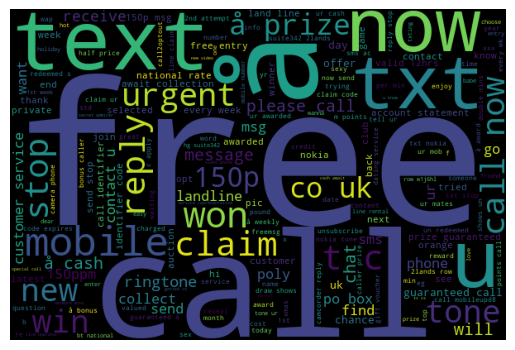

In [137]:
visualize(1) # spam

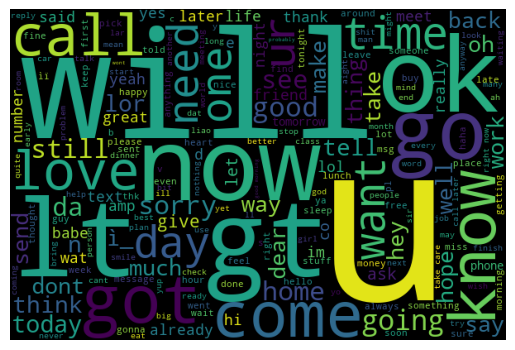

In [138]:
visualize(0) # not spam